# Проект: классификация

In [865]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [866]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [867]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [868]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [869]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def get_float(value):
    if type(value) == str:
        value = value.replace(' ', '').replace('$', '').replace(',', '.')
        return float(value)

df['balance'] = df['balance'].apply(get_float)
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [870]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'].fillna(df['balance'].median(), inplace=True)
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [871]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
job_mode = df['job'].mode()[0]
education_mode = df['education'].mode()[0]

df['job'].loc[df['job']=='unknown'] = job_mode
df['education'].loc[df['education']=='unknown'] = education_mode

mask1 = df['job'] == job_mode
mask2 = df['education'] == education_mode
round(df['balance'][mask1 & mask2].mean(), 3)

1598.883

### Задание 6

In [872]:
df['balance'].quantile(0.25)

123.0

In [873]:
df['balance'].quantile(0.75)

1699.0

In [874]:
# удалите все выбросы для признака balance
# ваш код
q1 = df['balance'].quantile(0.25)
q3 = df['balance'].quantile(0.75)
low_bound = q1 - 1.5 * (q3-q1)
high_bound = q3 + 1.5 * (q3-q1)
print(low_bound, high_bound)
df = df[(df['balance'] >= low_bound) & (df['balance'] <= high_bound)]
df.shape[0]

-2241.0 4063.0


10105

## Часть 2:  Разведывательный анализ

### Задание 1

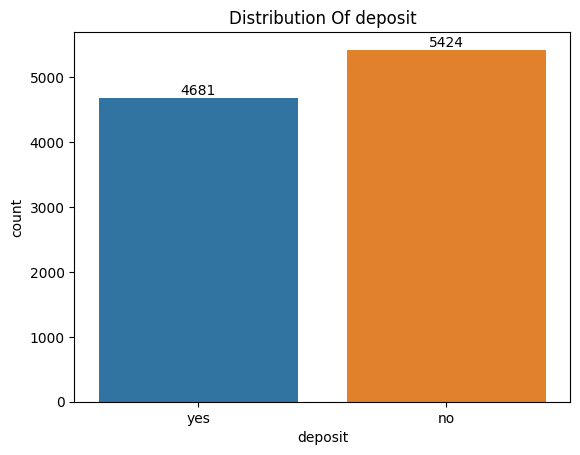

In [875]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
fig = sns.countplot(x=df['deposit'], hue=df['deposit'])
fig.set_title("Distribution Of deposit")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

### Задания 2 и 3

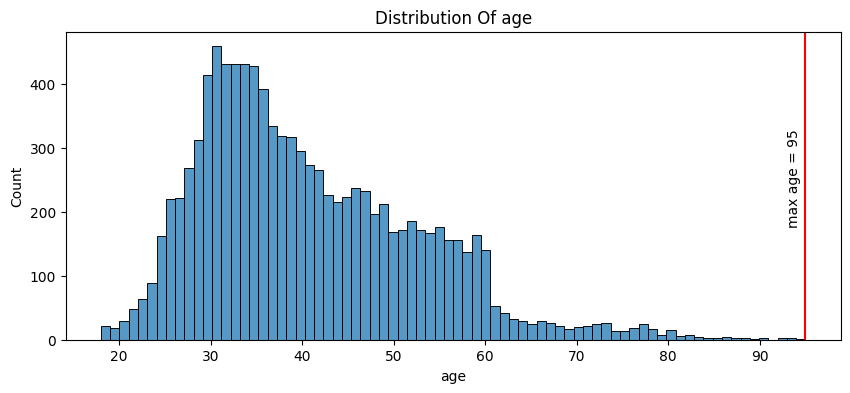

In [876]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
fig = plt.figure(figsize=(10,4))
fig = sns.histplot(df['age'], bins=df['age'].value_counts().shape[0])
fig.set_title('Distribution Of age')
fig2 = plt.axvline(df['age'].max(), color='red')
plt.text(x=df['age'].max()-2, y=180, s=f'max age = {df["age"].max()}', rotation=90)
plt.show()

Возраст большинства клиентов находится где-то между 25 и 60 годами. Распределение напоминает логнормальное. Максимальный возраст 95 лет.

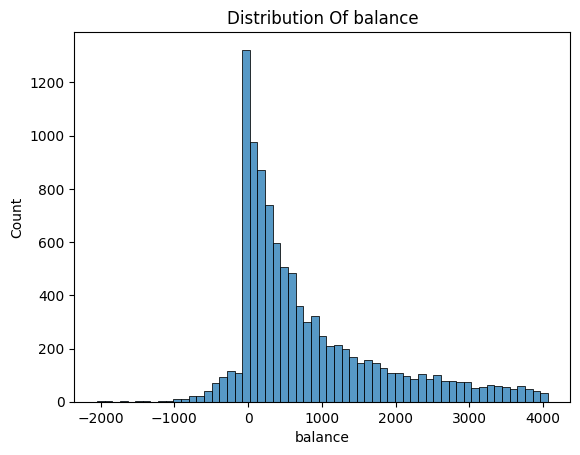

In [877]:
fig = sns.histplot(df['balance'])
fig.set_title('Distribution Of balance')
plt.show()

Основной баланс клиентов находится в районе нуля. Распределение также напоминает логнормальное или нормальное, по крайней мере в правой части. В области с отрицательным балансом график резко обрывается.

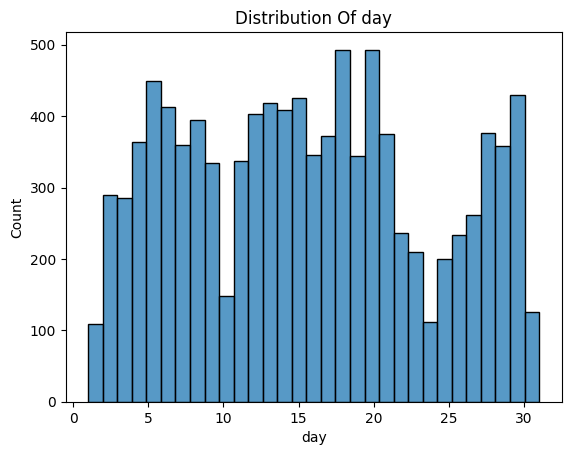

In [878]:
fig = sns.histplot(df['day'], bins=df['day'].value_counts().shape[0])
fig.set_title('Distribution Of day')
plt.show()

Переменная day вряд ли имеет много смысла в отрыве от месяца, т.к. показывает только число. Даже каких-то выводов об активности в начале, конце или середине месяца сложно сделать. По какой-то причине есть провал на 10-го и между 22-м и 27-м числами, достигая минимума 24-го. Есть ли в этом какая-то закономерность или это просто статистический артефакт - непонятно. Если для 10-го это скорее так, то 5-дневный провал с минимумом на 24 напоминает снижение и последующий рост, но, возможно, это просто совпадение.

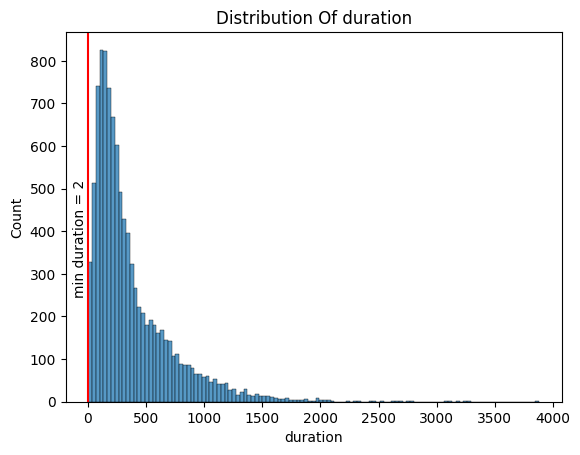

In [879]:
fig = sns.histplot(df['duration'])
fig.set_title('Distribution Of duration')
fig2 = plt.axvline(df['duration'].min(), color='red')
plt.text(x=df['duration'].min()-130, y=250, s=f'min duration = {df["duration"].min()}', rotation=90)
plt.show()

Здесь распределение очень похоже даже не на логнормальное, а на степенной закон. Минимальная длительность контакта - 2 секунды.

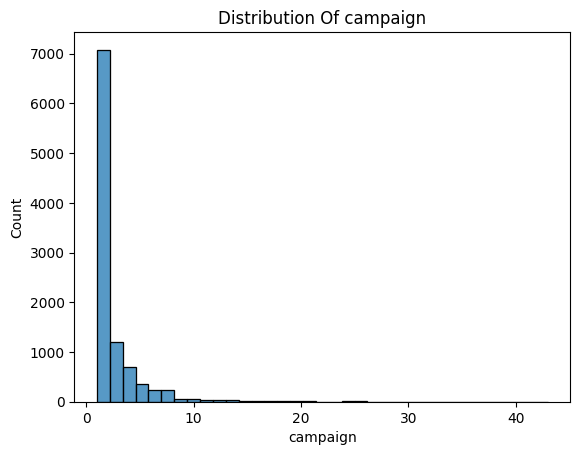

In [880]:
fig = sns.histplot(df['campaign'], bins=df['campaign'].value_counts().shape[0])
fig.set_title('Distribution Of campaign')
plt.show()

Количесвто контактов с одним клиентом тоже убывает, напоминая степенной закон или логнормальное распределение. Чаще всего с одним клиентом был всего один контакт.

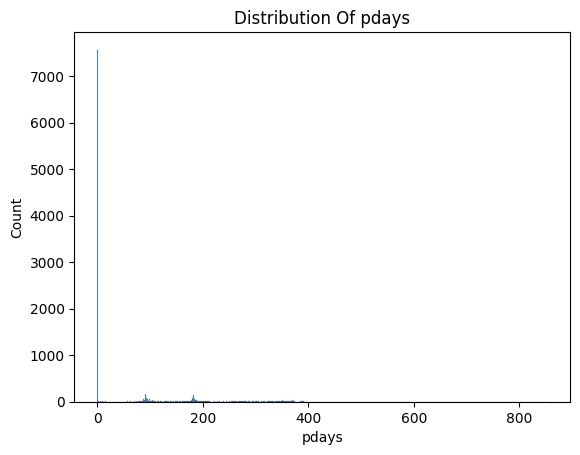

In [881]:
fig = sns.histplot(df['pdays'], bins=df['pdays'].value_counts().shape[0])
fig.set_title('Distribution Of pdays')
plt.show()

Количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании. Подавляющее большинство значений равно -1. Скорее всего так помечены пропуски, но т.к. не было требования их удалять, то пока оставим, как есть. 

Можно было бы предположить, что так просто помечены клиенты, с которыми просто ещё не было контактов, но на предыдущем графике видно, что отсутствуют значения в нуле, и значит хотя бы один контакт за текущую кампанию был с каждым клиентом. Выглядит это всё несколько противоречиво, но допустим.

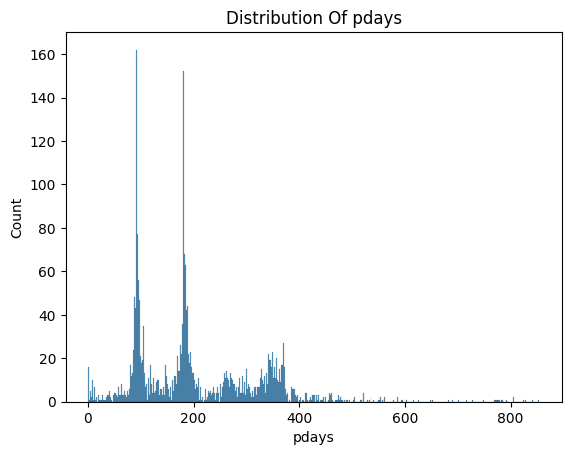

In [882]:
fig = sns.histplot(df['pdays'][df['pdays']!=-1], bins=df['pdays'][df['pdays']!=-1].value_counts().shape[0])
fig.set_title('Distribution Of pdays')
plt.show()

Если же убрать значения с -1, то можно заметить явные пики около значений 90 и 180, а также чуть менее явные около 270 и 360. Судя по всему маркетинговые кампании проводятся раз в 3 месяца, и с большей частью клиентов был контакт хотя бы в одной из двух предыдущих.

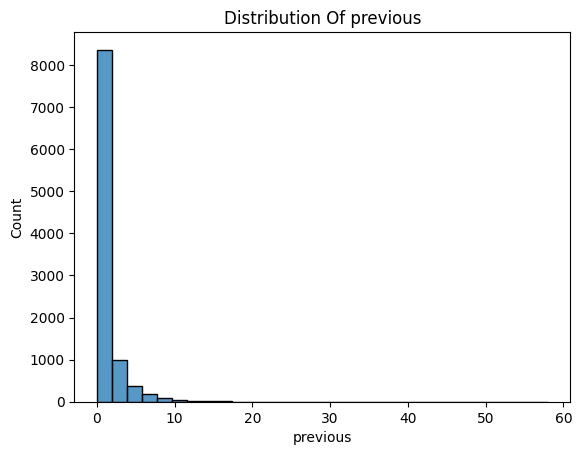

In [883]:
fig = sns.histplot(df['previous'], bins=df['previous'].value_counts().shape[0])
fig.set_title('Distribution Of previous')
plt.show()

In [884]:
df['pdays'][df['previous']==0].value_counts()

pdays
-1    7568
Name: count, dtype: int64

С большей частью клиентов вообще не было контактов во время маркетинговых кампаний.
Попробуем сравнить это количество с количеством значений -1 в pdays.

In [885]:
df['previous'].value_counts().head()

previous
0    7568
1     796
2     612
3     391
4     223
Name: count, dtype: int64

In [886]:
df['pdays'].value_counts().head()

pdays
-1      7568
 92       88
 182      77
 181      75
 91       74
Name: count, dtype: int64

Количество значений полностью совпадает, а это значит, что -1 помечены не пропуски, а клиенты, с которыми в принципе не контактировали во время предыдущих кампаний.

### Задания 4 и 5

number of jobs: 11


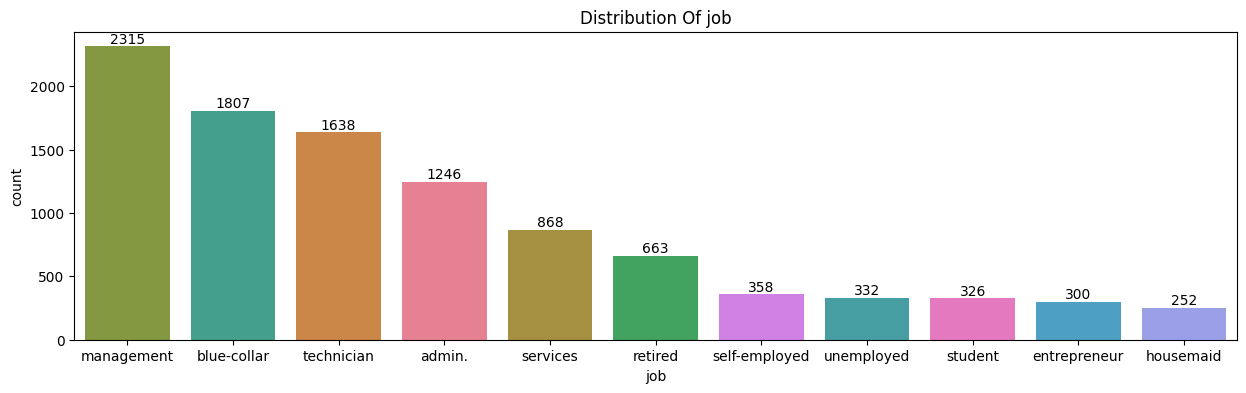

In [887]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
print(f'number of jobs: {df["job"].value_counts().shape[0]}')

fig = plt.figure(figsize=(15,4))
fig = sns.countplot(x=df['job'], hue=df['job'], order=df['job'].value_counts().index)
fig.set_title("Distribution Of job")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

Существенно большую долю клиентов банка составляют наёмные работники разных сфер.

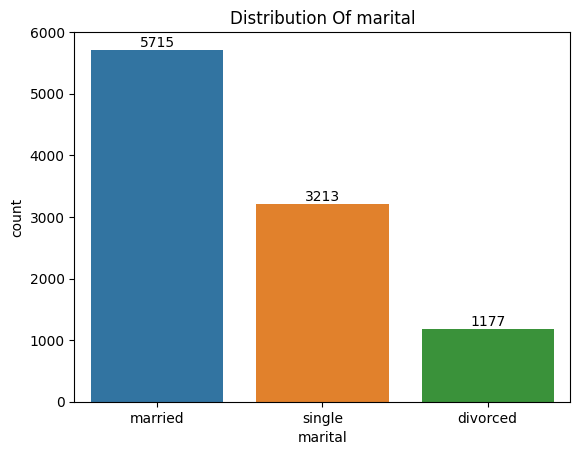

In [888]:
fig = sns.countplot(x=df['marital'], hue=df['marital'])
fig.set_title("Distribution Of marital")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

Доля клиентов в браке превышает доли одиноких и разведённых вместе взятые.

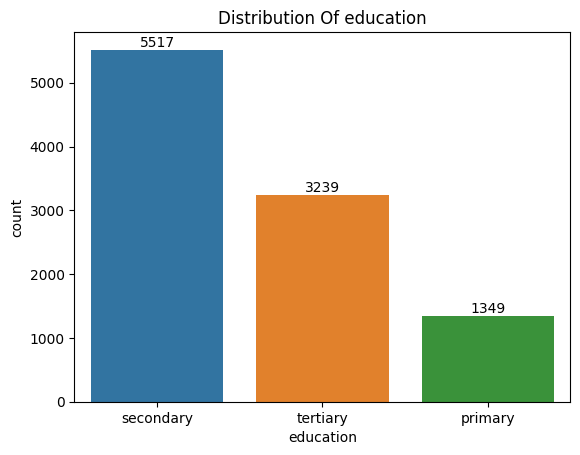

In [889]:
fig = sns.countplot(x=df['education'], hue=df['education'])
fig.set_title("Distribution Of education")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

Большая часть имеет среднее образование, высшее - около трети всех клиентов.

In [890]:
df['default'].value_counts().index.to_list()

['no', 'yes']

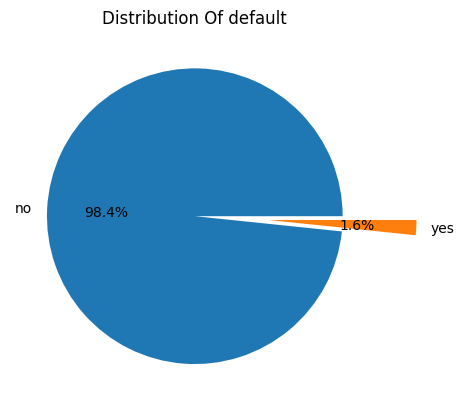

In [891]:
plt.pie(df['default'].value_counts().to_list(), labels=df['default'].unique(), autopct='%1.1f%%', explode=[0,0.5])
plt.title("Distribution Of default")
plt.show()

Доля клиентов, имеющих просроченный кредит меньше 2 процентов.

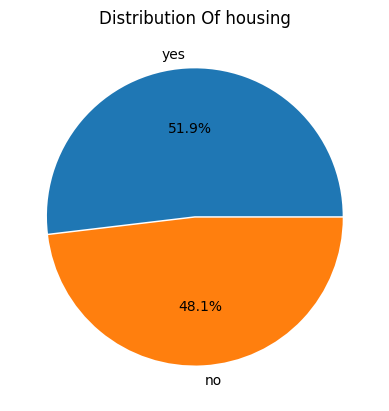

In [892]:
plt.pie(df['housing'].value_counts().to_list(), labels=df['housing'].unique(), autopct='%1.1f%%', explode=[0,0.01])
plt.title("Distribution Of housing")
plt.show()

Кредиты на жильё имеет чуть больше половины всех клиентов.

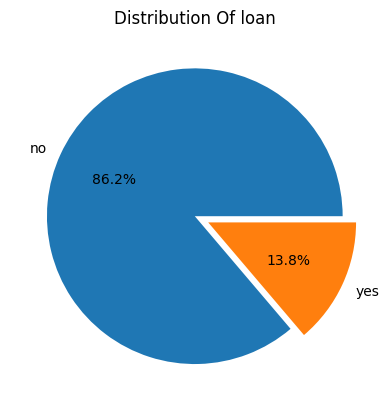

In [893]:
plt.pie(df['loan'].value_counts().to_list(), labels=df['loan'].unique(), autopct='%1.1f%%', explode=[0,0.1])
plt.title("Distribution Of loan")
plt.show()

Большая часть клиентов не имеет кредитов на личные нужны.

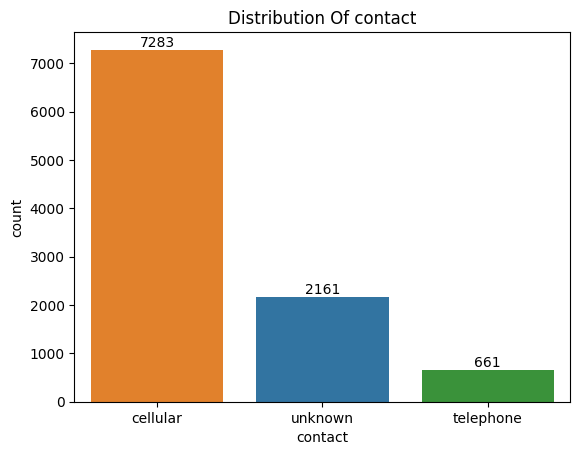

In [894]:
fig = sns.countplot(x=df['contact'], hue=df['contact'], order=df['contact'].value_counts().index)
fig.set_title("Distribution Of contact")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

Большая часть контактов представлена мобильными номерами.

number of months: 12


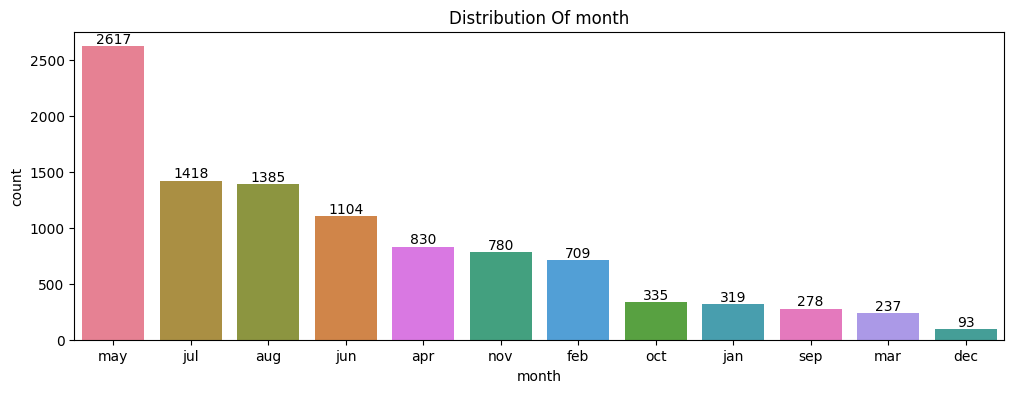

In [895]:
print(f'number of months: {df["month"].value_counts().shape[0]}')

fig = plt.figure(figsize=(12,4))
fig = sns.countplot(x=df['month'], hue=df['month'], order=df['month'].value_counts().index)
fig.set_title("Distribution Of month")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

Большая часть контактов с клиентами происходит в мае, меньше в летние месяцы, и ещё чуть меньше в апреле, ноябре и феврале.

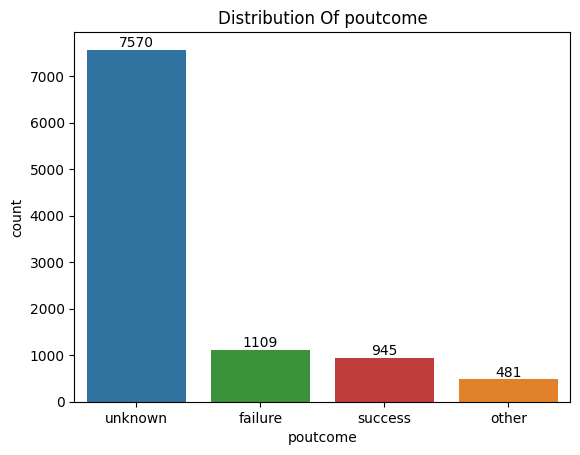

In [896]:
fig = sns.countplot(x=df['poutcome'], hue=df['poutcome'], order=df['poutcome'].value_counts().index)
fig.set_title("Distribution Of poutcome")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

Число неизвестных результатов прошлой маркетинговой кампании отличается от числа клиентов, с которыми не контактировали до этого всего на 2.
Выведем две эти позиции.

In [897]:
df[(df['poutcome']=='unknown')&(df['previous']!=0)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
2848,26,admin.,single,secondary,no,338.0,no,no,cellular,29,oct,209,1,188,2,unknown,yes
5220,61,retired,married,tertiary,no,3140.0,yes,yes,cellular,6,aug,975,4,98,1,unknown,yes


Вроде ничего необычного. В отличие от 7568 остальных, в данной ситуации unknown - это обычный пропуск. Но т.к. в остальных случаях это значение несёт информацию, а здесь не понятно, чем их заполнять, оставим, как есть.

### Задание 6

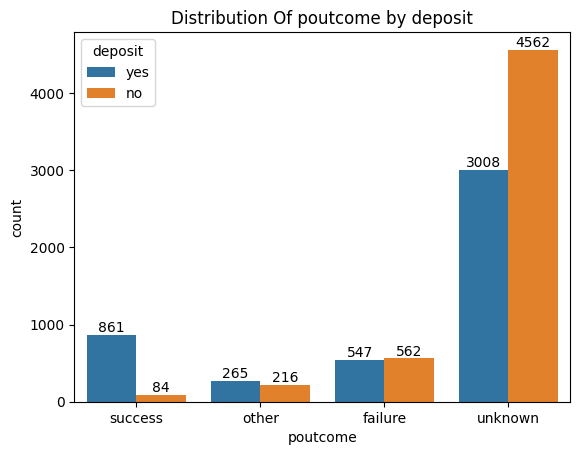

In [898]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
# Группируем таблицу по значениям статуса прошлой и текущей акций
# Выбираем успешные статусы и сортируем по доле успехов
# Используем индексы для порядка вывода столбцов на гистограмме (сначала больший процент успеха)
order = df.groupby('poutcome')['deposit'].value_counts(normalize=True, sort=True).unstack()['yes'].sort_values(ascending=False).index

fig = sns.countplot(x=df['poutcome'], hue=df['deposit'], order=order)
fig.set_title("Distribution Of poutcome by deposit")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

Доля успехов больше всего в статусе 'success' для предыдущей компнаии, что логично.

### Задание 7

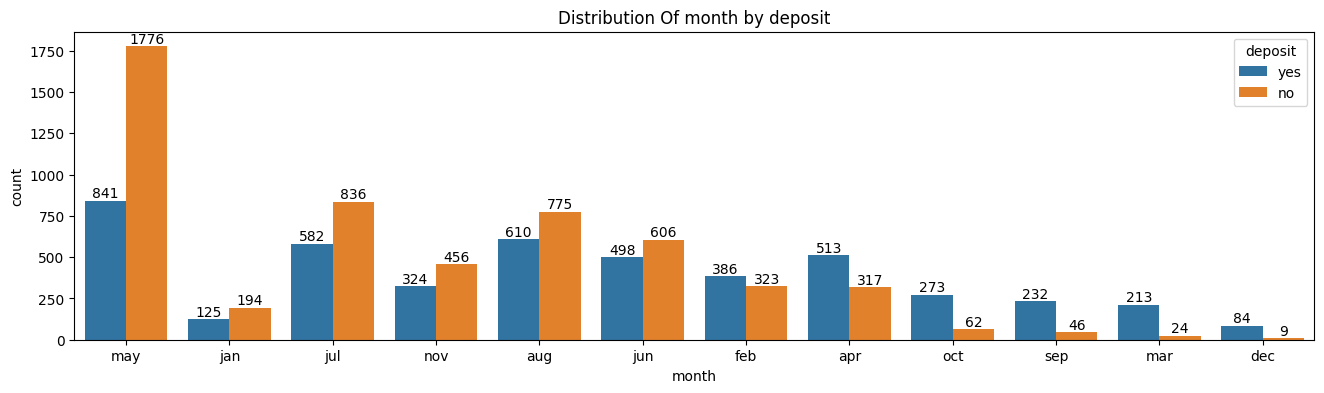

In [899]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
# Создаём переменную для порядка столбцов на гистограмме
order = df.groupby('month')['deposit'].value_counts(normalize=True, sort=True).unstack()['yes'].sort_values().index

fig = plt.figure(figsize=(16, 4))
fig = sns.countplot(x=df['month'], hue=df['deposit'], order=order)
fig.set_title("Distribution Of month by deposit")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

Любопытно, что наибольшая доля отказов приходится на май, как и самое большое число контактов во время текущей компании.

### Задание 8

In [900]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age_cat(value):
    if value < 30:
        cat = '<30'
    elif value < 40:
        cat = '30-40'
    elif value < 50:
        cat = '40-50'
    elif value < 50:
        cat = '50-60'
    else: 
        cat = '60+'
    return cat

age_cat = df['age'].apply(get_age_cat)
age_cat

0          60+
1          60+
2        40-50
3          60+
4          60+
         ...  
11157    30-40
11158    30-40
11159    30-40
11160    40-50
11161    30-40
Name: age, Length: 10105, dtype: object

In [901]:
age_cat = pd.concat([df['deposit'], age_cat], axis=1)
age_cat

,deposit,age
0,yes,60+
1,yes,60+
2,yes,40-50
3,yes,60+
4,yes,60+
...,...,...
11157,no,30-40
11158,no,30-40
11159,no,30-40
11160,no,40-50


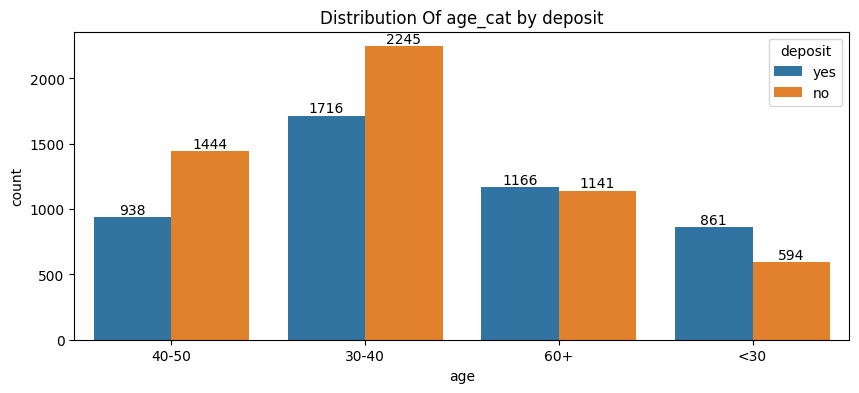

In [902]:
# Порядок выведения возрастных групп по увеличеню доли открытых депозитов
order = age_cat.groupby('age')['deposit'].value_counts(normalize=True, sort=True).unstack()['yes'].sort_values().index

fig = plt.figure(figsize=(10, 4))
fig = sns.countplot(x=age_cat['age'], hue=df['deposit'], order=order)
fig.set_title("Distribution Of age_cat by deposit")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

### Задания 9 и 10

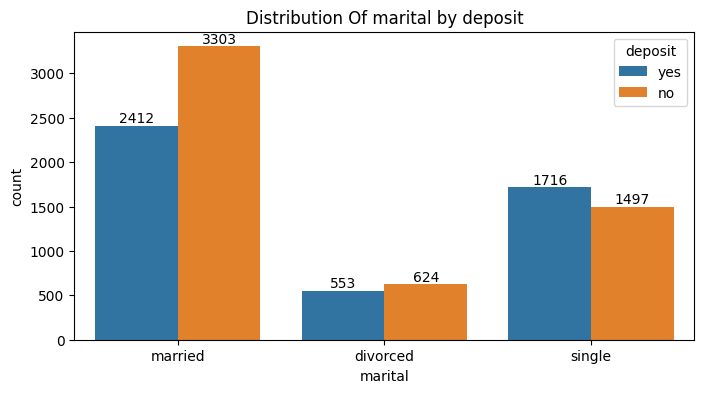

In [903]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
order = df.groupby('marital')['deposit'].value_counts(normalize=True, sort=True).unstack()['yes'].sort_values().index

fig = plt.figure(figsize=(8, 4))
fig = sns.countplot(x=df['marital'], hue=df['deposit'], order=order)
fig.set_title("Distribution Of marital by deposit")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

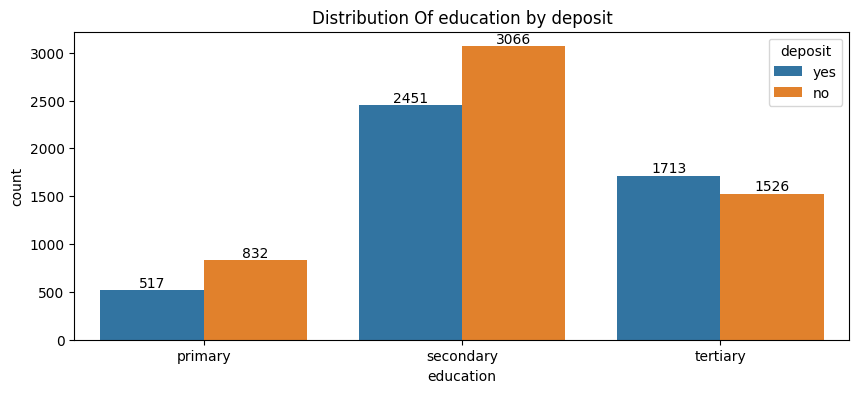

In [904]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
order = df.groupby('education')['deposit'].value_counts(normalize=True, sort=True).unstack()['yes'].sort_values().index

fig = plt.figure(figsize=(10, 4))
fig = sns.countplot(x=df['education'], hue=df['deposit'], order=order)
fig.set_title("Distribution Of education by deposit")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

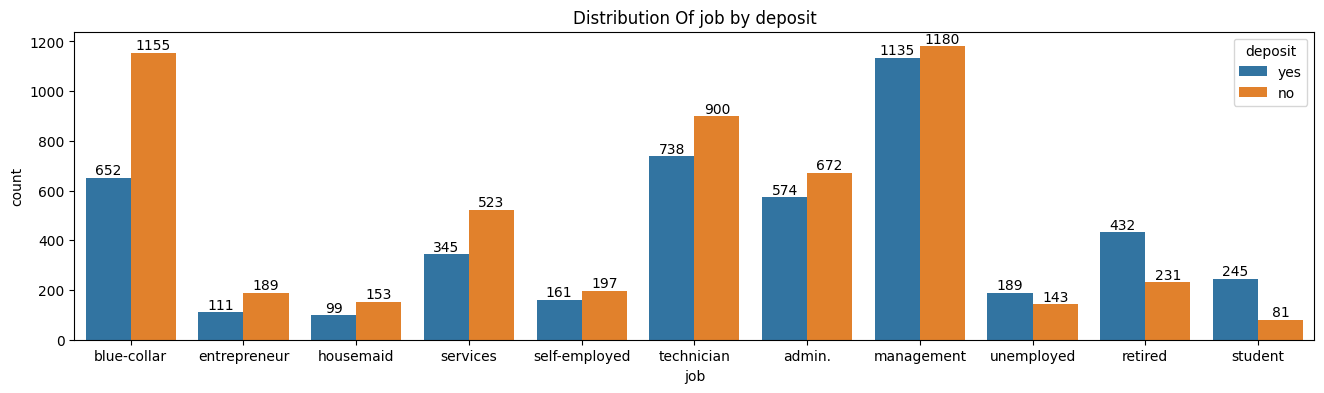

In [905]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
order = df.groupby('job')['deposit'].value_counts(normalize=True, sort=True).unstack()['yes'].sort_values().index

fig = plt.figure(figsize=(16, 4))
fig = sns.countplot(x=df['job'], hue=df['deposit'], order=order)
fig.set_title("Distribution Of job by deposit")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

### Задание 11

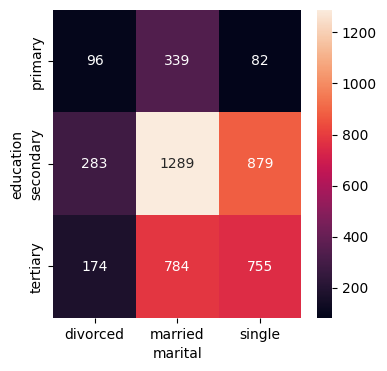

In [906]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
fig = plt.figure(figsize=(4, 4))
sns.heatmap(df[df['deposit']=='yes'].groupby('education')['marital'].value_counts().unstack(), annot=True, fmt='g')
plt.show()

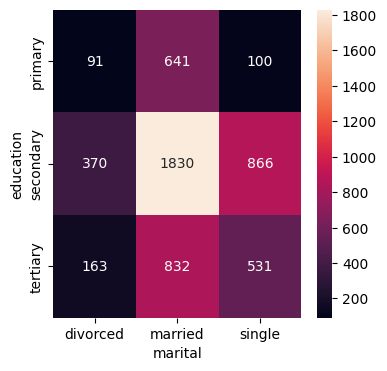

In [907]:
fig = plt.figure(figsize=(4, 4))
sns.heatmap(df[df['deposit']=='no'].groupby('education')['marital'].value_counts().unstack(), annot=True, fmt='g')
plt.show()

Женатых людей со средним образованием больше всего в обеих группах.

## Часть 3: преобразование данных

### Задание 1

In [908]:
# преобразуйте уровни образования
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
print(df['education'].sum()) 

11995


In [909]:
age_cat = age_cat.rename(columns={'age':'age_cat'})
le = LabelEncoder()
age_cat['age_cat'] = le.fit_transform(age_cat['age_cat'])

### Задания 2 и 3

In [910]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
print(f'Answer for 4.2: {round(df["deposit"].std(), 3)}')

df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)
print(f'Answer for 4.3: {round((df["default"].mean() + df["housing"].mean() + df["loan"].mean()), 3)}')

Answer for 4.2: 0.499
Answer for 4.3: 0.635


### Задание 4

In [911]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], dtype='int')

### Задания 5 и 6

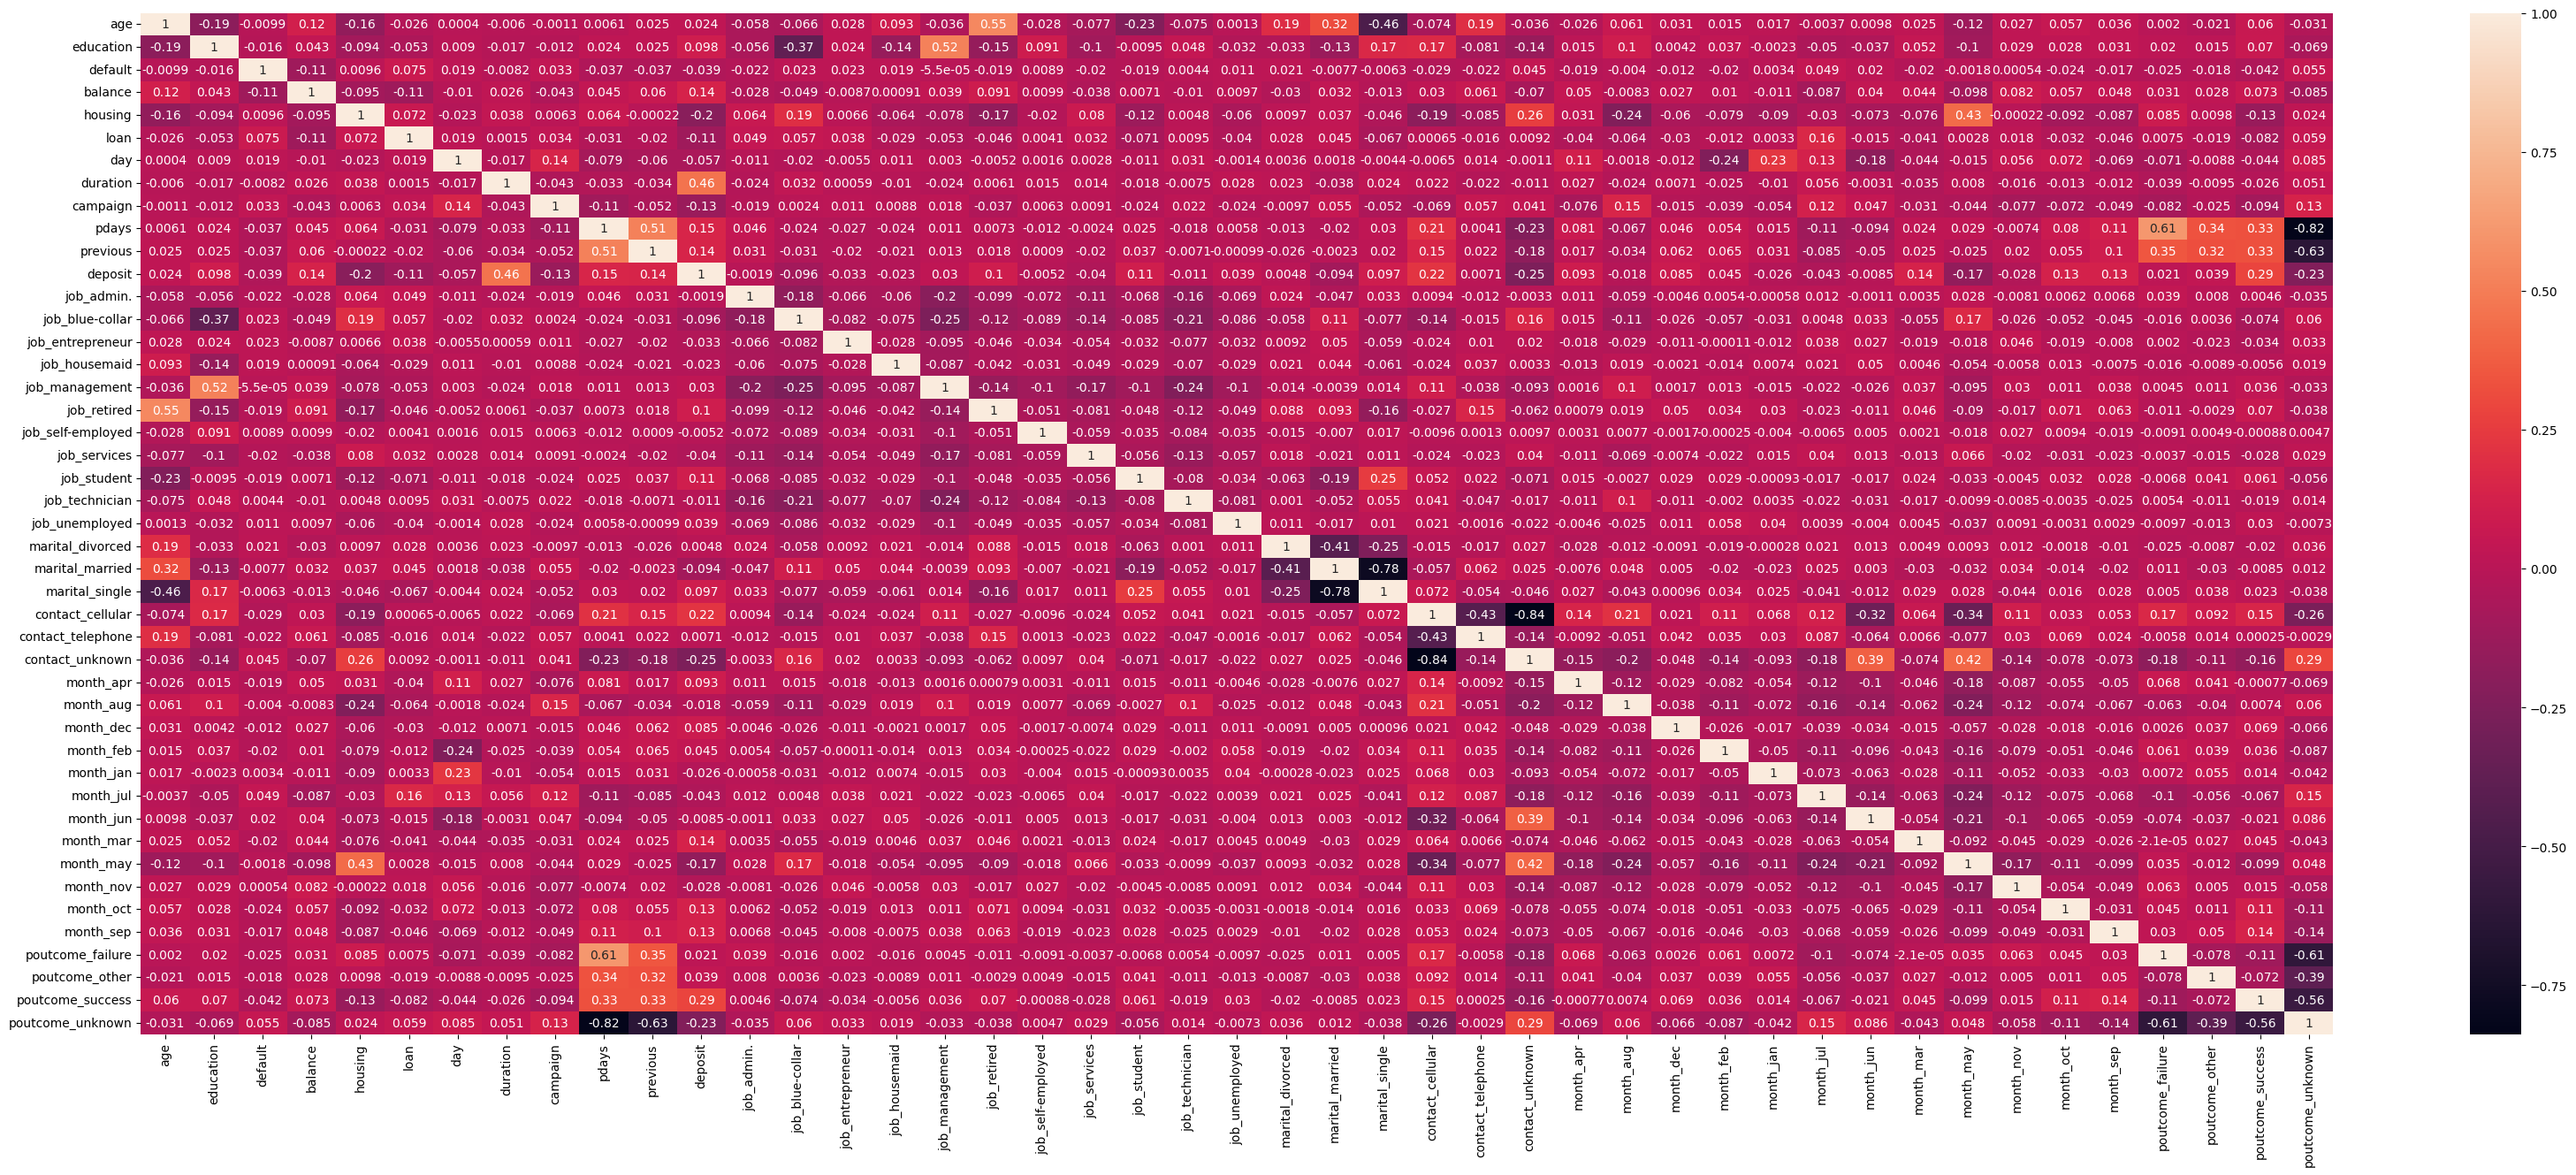

In [912]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig = plt.figure(figsize=(40, 15))
sns.heatmap(df.corr(), annot=True)
plt.show()

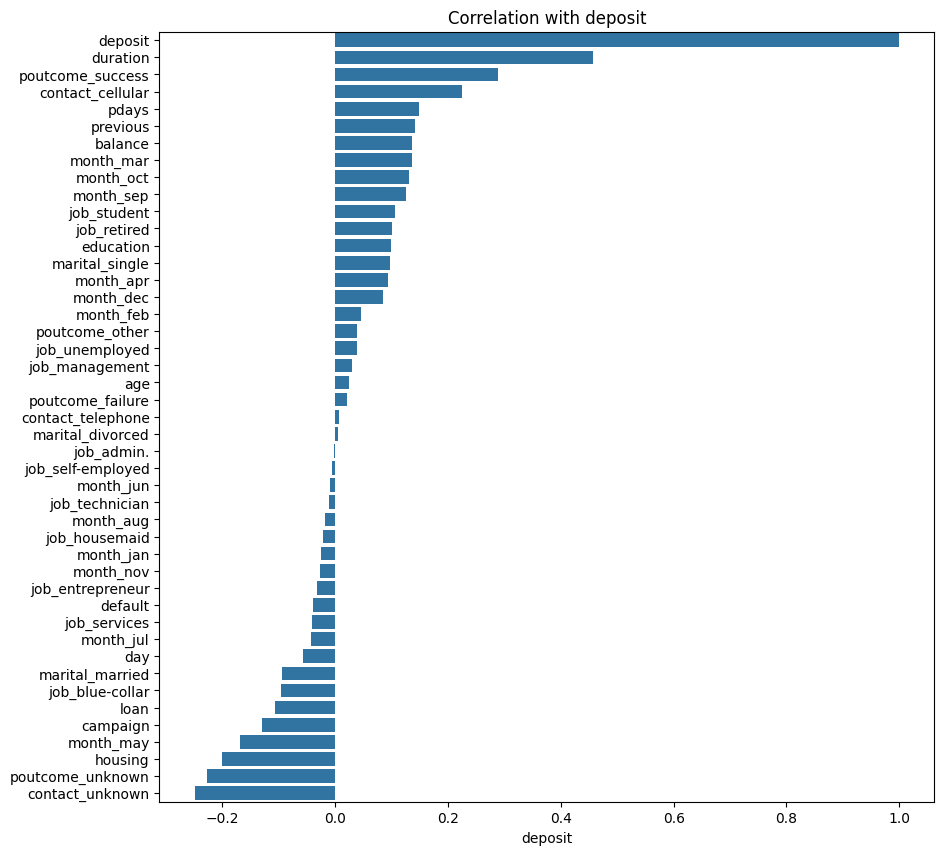

In [913]:
fig = plt.figure(figsize=(10, 10))
fig = sns.barplot(df.corr()['deposit'].sort_values(ascending=False), orient='h')
fig.set_title("Correlation with deposit")
plt.show()

### Задания 7 и 8

In [914]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [915]:
# рассчитайте необходимые показатели
print(f'Answer 4.7: {X_test.shape[0]}')
print(f'Answer 4.8: {round(y_test.mean(), 2)}')

Answer 4.7: 3335
Answer 4.8: 0.46


### Задание 9

In [916]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
columns = selector.get_feature_names_out()
print(columns)
X_train = X_train[columns]
X_test = X_test[columns]

['balance' 'housing' 'loan' 'duration' 'campaign' 'pdays' 'previous'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [917]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

round(X_test_scaled[:, 0].mean(), 2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

: 

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

: 

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

: 

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

: 

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

: 

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

: 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

: 

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

: 